In [6]:
import os
import time
import sys
import json
import numpy as np
import ipyvolume as ipv
from pathlib import Path
import numpy as np
import random
from datetime import datetime

from tyssue import Sheet, config
from tyssue.io import hdf5
from tyssue.generation import ellipsoid_sheet
from tyssue.draw.ipv_draw import view_ipv
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.dynamics import effectors, units
from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics.factory import model_factory
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.behaviors.events import EventManager
from tyssue.topology.sheet_topology import remove_face
from tyssue.utils.decorators import do_undo
from tyssue.utils import to_nd
from tyssue.io import hdf5


from invagination.ellipsoid import EllipsoidGeometry as geom
from invagination.ellipsoid import VitellineElasticity
from invagination.delamination import (define_mesoderm,
                                       check_enter_in_process,
                                       check_tri_faces,
                                       type1_transition)

from invagination.plots import mesoderm_position


import matplotlib.pyplot as plt

%matplotlib inline

SIM_DIR = Path('/home/admin-suz/Documents/Simulations')
#SIM_DIR = Path('/media/admin-suz/Sophie/2018/datas/Simulations')


In [ ]:
import datetime

today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_largeur_gaussienne'
try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [ ]:
class RadialTension(effectors.AbstractEffector):
    
    dimensions = units.line_tension
    magnitude = 'radial_tension'
    label = 'Apical basal tension'
    element = 'vert'
    specs = {'vert':{'is_active',
             'height',
             'radial_tension'}}

    @staticmethod
    def energy(eptm):
        return eptm.vert_df.eval(
            'height * radial_tension * is_active')
         
    @staticmethod
    def gradient(eptm):
        grad = height_grad(eptm) * to_nd(
            eptm.vert_df.eval('radial_tension'), 3)
        grad.columns = ['g'+c for c in eptm.coords]
        return grad, None
    
    
EllipsoidSModel = model_factory(
    [
    RadialTension,
    VitellineElasticity,
    effectors.LineTension,
    effectors.FaceContractility,
    effectors.FaceVolumeElasticity,
    ], effectors.FaceAreaElasticity)


EllipsoidBModel = model_factory(
    [
    RadialTension,
    VitellineElasticity,
    #effectors.LineTension,
    effectors.FaceContractility,
    effectors.FaceAreaElasticity,
    effectors.CellVolumeElasticity,
    ], effectors.FaceAreaElasticity)


model = EllipsoidBModel
geom = EllipsoidBGeometry

In [ ]:
dsets = hdf5.load_datasets('../data/hf5/ellipsoid_sheet_init.hf5',
                           data_names=['vert', 'edge', 'face', 'cell'])


with open('../data/json/ellipsoid.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('ellipse', dsets, specs)

# Modify some initial value
sheet.settings['threshold_length'] = 1e-3
sheet.settings['vitelline_space'] = 0.2
sheet.vert_df['radial_tension'] = 0.
sheet.cell_df['prefered_vol'] = 4539601.384437251
sheet.cell_df['vol_elasticity'] = 3.e-6

fig, ax = quick_edge_draw(sheet, coords=list('zx'))

In [ ]:
solver_kw = {'minimize': {'method': 'L-BFGS-B',
                          'options': {'ftol': 1e-8,
                                      'gtol': 1e-8}}}

## Define cells in the mesoderm

In [ ]:
# Define rectangular mesoderm
#define_cell_in_mesoderm(sheet, 0.3, 0.7 ,0.05, 0.95)

# Define ovoid mesoderm
define_ovoid_mesoderm(sheet, 0, 0, 145, 40)

mesoderm = sheet.face_df[sheet.face_df.is_mesoderm].index
delaminating_cells = sheet.face_df[sheet.face_df['is_mesoderm']].index



print('number of apoptotic cells: {}'.format(delaminating_cells.size))
mesoderm_position(sheet, delaminating_cells)

In [ ]:
from tyssue.behaviors.events import EventManager
from tyssue.topology.sheet_topology import remove_face
from tyssue.utils.decorators import do_undo
import os


import logging
logger = logging.Logger('event_log')

from tyssue.io import hdf5


@do_undo
def run_sim(sheet, mesoderm, geom, model, dirname, largeur_gauss):
    solver = Solver
    
    # logger initiation
    event_logfile = os.path.join(dirname, 'events.log')
    hdlr = logging.FileHandler(event_logfile)
    hdlr.setLevel('INFO')
    logger.addHandler(hdlr)
    
    # initiate df for monitorign delamination process
    df = initiate_monitoring_process(sheet, mesoderm)
    list_cell_mesoderm = list(mesoderm)
    cell_in_delamination_process = []
    
    #Initiate manager
    manager = EventManager('face')

    
    t=0
    stop = 500
    while manager.current and t < stop:
        # Clean radial tension on all vertices
        sheet.vert_df['radial_tension'] = 0
        manager.execute(sheet)
        res = solver.find_energy_min(sheet, geom, model, **solver_kw)
        
        # add noise on vertex position to avoid local minimal.
        sheet.vert_df[['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        geom.update_all(sheet)

        figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(t))
        hdfname = figname[:-3]+'hf5'
        hdf5.save_datasets(hdfname, sheet)      
        
        # Test if face are done their transition or not (= if they are pulling)
        for f in cell_in_delamination_process : 
            face = sheet.idx_lookup(f, 'face')
            if face is not None : 
                if df.loc[f, 'transition'] == 0 :
                    if sheet.face_df.loc[face, 'area'] < sheet.settings['delamination']['critical_area'] : 
                        df.loc[f, 'transition'] = t            
        
        # Add cells in delamination process if they are authorized
        check_enter_in_process(sheet, manager, list_cell_mesoderm, 
                                    cell_in_delamination_process, df, t, 
                                    largeur_gauss, 2)
            
        # Check if cell is still in delamination process
        # if not put time in end column.
        temp_queu = manager.next.copy()
        for f in cell_in_delamination_process:
            present = False
            for tuple in temp_queu :
                if f in tuple : 
                    present = True
                    break                    
            if present == False : 
                df.loc[f,'end'] = t
                cell_in_delamination_process.remove(f)
        
        # Add cells with initially 3 neighbourghs to be eliminated
        check_tri_faces(sheet, manager)
        # Add T1 transition for face with at least one edge shorter than critical length
        [manager.append(type1_transition, f, kwargs=sheet.settings['T1']) for f in sheet.edge_df[
            sheet.edge_df['length'] < sheet.settings['T1']['critical_length']]['face'].unique()]
    
    
        manager.update()
        df.to_csv (os.path.join(dirname,'time_position.csv'))
        t+=1
        
        
    logger.removeHandler(hdlr)
    return sheet


In [ ]:
def delamination_process(sheet, contractility_rate, critical_area, radial_tension, largeur_gauss):

    # Directory definition 
    dirname = '{}_contractility_{}_critical_area_{}_radialtension_{}_largeur_gauss'.format(
                contractility_rate, critical_area, radial_tension, largeur_gauss)
    dirname = os.path.join(sim_save_dir, dirname)
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass
    
    settings = {'contract_rate': contractility_rate,
            'critical_area': critical_area,
            'radial_tension': radial_tension,
            'nb_iteration':0,
            'nb_iteration_max':20,
            'contract_neighbors':True,
            'critical_area_neighbors':10,
            'geom': geom}
    
    solver = Solver
    
    # Add some information to the sheet
    sheet2 = sheet.copy(deep_copy=True)
    
    sheet2.face_df['id'] = sheet2.face_df.index.values
    sheet2.settings['delamination'] = settings
    
    settings2 = {'critical_length':0.3}
    sheet2.settings['T1'] = settings2
    #""" Initiale find minimal energy
    # To be sure we are at the equilibrium
    res = solver.find_energy_min(sheet2, geom, model, **solver_kw)
   
    sheet2 = run_sim(sheet2, delaminating_cells, geom, model, dirname, largeur_gauss)

    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')
    

In [ ]:
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))

radial_tension = [0]
contractility_percent = [8]
contractility_rate = [1+c/100 for c in contractility_percent]
largeur_gauss = [2.5, 10, 17, 25, 40]

for rad in radial_tension:
    for contracts in contractility_rate:
        for lg in largeur_gauss : 
            print ('\tlargeur gauss : ' + str(lg))
            delamination_process(sheet, contracts, 5, rad, lg)

global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

In [ ]:
# Multi-execution parallel 
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))
num_cores = multiprocessing.cpu_count()


radial_tension = [0]
contractility_percent = [8]
contractility_rate = [1+c/100 for c in contractility_percent]


contractility_rate, radial_tension = np.meshgrid(contractility_rate, radial_tension)

results = Parallel(n_jobs=2)(delayed(delamination_process)(
    sheet, c, 5, r) for c, r in zip(contractility_rate.ravel(), radial_tension.ravel()))

global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)


# Analysis

In [1]:
from invagination.morphometry import (parse_ply, 
                                      get_borders, 
                                      get_morphometry,
                                      get_ventral_patch,
                                      analyse,
                                      grided_graph,
                                      color_plot_silico,
                                      color_plot_vivo)


In [7]:
base_dir = '/media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/MorphographX/EmbryonsInVivo'

print('Data sub-directories:')
print('\t', *os.listdir(base_dir), sep='\n\t')
print('----------')
data_dirs = []
for tree in os.walk(base_dir):
    if not tree[1]: # only dir without subdirs
        data_dirs.append((Path(tree[0]), tree[-1]))
data_dir = data_dirs[:][0]

# Collected in vivo 
collected_vivo = {}
for data_dir in data_dirs:
    print(f'Treating {data_dir[0]}')
    figures, axes = None, None
    plys = [f for f in data_dir[1] if f.endswith('.ply')]
    for data_file in plys:
        basename = '_'.join((data_dir[0].parent.stem.replace(' ', ''),
                             Path(plys[0]).stem))
        try:
            dir_name_vivo = data_file.split('_')[0]
            print (dir_name_vivo)
            centers, figures, axes = analyse(data_dir[0], data_file,
                                             basename=basename,
                                             figures=figures, 
                                             axes=axes,
                                             show=True,
                                             save=True)
            centers.x = centers.x
            collected_vivo[basename] = centers
        except Exception as e:
            print(f'Failed for {basename}')
            print(type(e))
            print(e)

    plt.close('all')

Data sub-directories:
	
	20161108
	20170519
	20170531
----------
Treating /media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/MorphographX/EmbryonsInVivo/20161108
20161108
Treating /media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/MorphographX/EmbryonsInVivo/20170519
20170519
Treating /media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/MorphographX/EmbryonsInVivo/20170531
20170531


In [8]:
# In vivo shift
in_vivo_shift = {'20161108' : 15, '20170519':-12, '20170531':35}
for name, centers in collected_vivo.items():
    centers['x'] = centers['x'] + in_vivo_shift[name.split('_')[1]]
    
# Area normalisation
for name, centers in collected_vivo.items():
    centers['area'] = centers['area']/centers['area'].mean()

# Symetriser 
means={}
stds={}
for name, centers in collected_vivo.items():
    centers['abs_x'] = np.abs(centers.x)
    centers['bin'] = np.digitize(centers['abs_x'], np.arange(0, 130, 3))
    means[name]=centers.groupby('bin').mean()
    means[name]['bin'] = means[name].index
    stds[name]=centers.groupby('bin').std()
    stds[name]['bin'] = stds[name].index

In [9]:
def in_vivo_plot (means, stds, column, normalized=False, ax=None):
    if ax is None : 
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    collected_means = pd.concat(means, ignore_index=True)
    collected_stds = pd.concat(stds, ignore_index=True)
    
    mean = collected_means.groupby('bin').mean()
    std = collected_means.groupby('bin').std().dropna()

    
    val=np.concatenate((-mean['abs_x'][0:len(std)][::-1], mean['abs_x'][0:len(std)]))
    
    
    val2 = np.concatenate(((mean[column] - std[column])[0:len(std)][::-1], 
                           (mean[column] - std[column])[0:len(std)]))
    val3 = np.concatenate(((mean[column] + std[column])[0:len(std)][::-1], 
                           (mean[column] + std[column])[0:len(std)]))

    ax.fill_between(val, val2,  
                        val3,
                        color="linen") 
    ax.plot(val, np.concatenate((mean[column][0:len(std)][::-1], mean[column][0:len(std)])), label='in vivo',color= 'black')
    

1.08_contractility_5_critical_area_0_radialtension_10_largeur_gauss


NameError: name 'define_time_depth_compare_to_vivo' is not defined

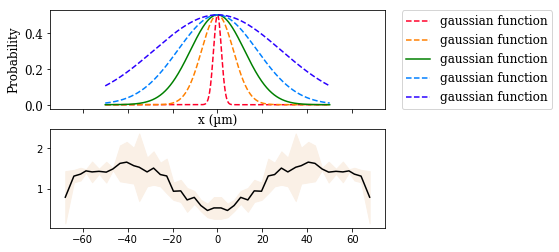

In [11]:
import itertools
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import pandas as pd


fig, (ax_init, ax) = plt.subplots(2, 1, sharex=True, sharey=False)

jet = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=4)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

color_d = {'2.5':scalarMap.to_rgba(4), 
           '10': scalarMap.to_rgba(3), 
           '17': scalarMap.to_rgba(2), 
           '25': scalarMap.to_rgba(1), 
           '40': scalarMap.to_rgba(0)}

color_d = {'2.5':(1.0, 0.0, 0.16, 1.0),
           '10': (1.0, 0.5, 0.0, 1.0), 
           '17': (0.0, 0.5, 0.0, 1.0), 
           '25': (0.0, 0.5, 1.0, 1.0), 
           '40': (0.16304347826086973, 0.0, 1.0, 1.0)}

n=2
x = np.linspace(-50,50, 1000)
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 2.5**n),'--', color = color_d['2.5'], label = 'gaussian function')
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 10**n), '--',color = color_d['10'], label = 'gaussian function')
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 17**n), color = color_d['17'], label = 'gaussian function')
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 25**n),'--', color = color_d['25'], label = 'gaussian function')
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 40**n),'--', color = color_d['40'], label = 'gaussian function')
ax_init.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'serif'})
ax_init.set_xlabel('x (µm)', size=12, family='serif')
ax_init.set_ylabel('Probability', size=12, family='serif')
for tick in ax_init.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('serif')
for tick in ax_init.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('serif')

# GRAPHE 2---------------------------------------------------------   

#SIM_DIR = Path('/home/admin-suz/Documents/Simulations')
SIM_DIR = Path('/media/admin-suz/Sophie/2018/datas/Simulations')
SIM_DIR = Path('/media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/')

dirname = SIM_DIR/'2018-05-18_largeur_gaussienne'
list_dir = os.listdir(dirname)


decallage_in_vivo = {'20161108' : 15, '20170519':-12, '20170531':35}
in_vivo_plot (means, stds, 'area', normalized=True, ax=ax)

    

i=0

for directory in list_dir : 
    print (directory)
    t, d =  define_time_depth_compare_to_vivo(os.path.join(dirname, directory))
    #print (time[directory.split('_')[7]])
    print (t) 
    
    
    sheet = open_sheet(os.path.join(dirname, directory), 0)
    sheet_mesoderm = sheet.extract('is_mesoderm')

    subset_mesoderm_face_df = sheet_mesoderm.face_df[
        (sheet_mesoderm.face_df['z'] > -20)
        & (sheet_mesoderm.face_df['z'] < 20) &
        (sheet_mesoderm.face_df['x'] > -2)
        & (sheet_mesoderm.face_df['x'] < 2)]

    depth_0 = np.mean(subset_mesoderm_face_df[
                  'rho'] + subset_mesoderm_face_df['height'])
    
    #sheet= open_sheet(os.path.join(dirname, directory), time[directory.split('_')[7]])
    sheet= open_sheet(os.path.join(dirname, directory), t)
    sheet_mesoderm = sheet.extract('is_mesoderm')
    subset_mesoderm_face_df = sheet_mesoderm.face_df[
            (sheet_mesoderm.face_df['z'] > -20)
            & (sheet_mesoderm.face_df['z'] < 20) &
            (sheet_mesoderm.face_df['x'] > -2)
            & (sheet_mesoderm.face_df['x'] < 2)]
    depth = depth_0 - np.mean(subset_mesoderm_face_df['rho'] + subset_mesoderm_face_df['height'])
    print ('invagination depth')
    print (depth)

    # area  = cell depth  

    sheet_mesoderm = sheet.extract('is_mesoderm')
    
    sheet_init_area = open_sheet(os.path.join(dirname, directory), 1)
    # area  = cell depth  
    sheet_mesoderm_init_area = sheet_init_area.extract('is_mesoderm')
    print ('cupule area mean')
    print (sheet_mesoderm.face_df.area.mean())
    print ('initial area mean')
    print (sheet_mesoderm_init_area.face_df.area.mean())
    sheet_mesoderm.face_df.area = sheet_mesoderm.face_df.area/sheet_mesoderm_init_area.face_df.area.mean()
    

    
    v, mean, std = mean_calculation(sheet_mesoderm.face_df, 'area')
    mean_reverse = mean[::-1]
    m = [(mean[i]+mean_reverse[i])/2 for i in range(len(mean))]
    if directory.split('_')[7] == '17':
        ax.plot(v, m, label=directory.split('_')[7], color = color_d[directory.split('_')[7]])
    else : 
        ax.plot(v, m, '--', label=directory.split('_')[7], color = color_d[directory.split('_')[7]])
    
    i=i+1
    

    
    
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'Arial'})

ax.set_xlabel('x (µm)', size=12, family='sans-serif', fontname='Arial')
ax.set_ylabel('Normalized area', size=12, family='sans-serif', fontname = 'Arial')
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')

ax.set_xlim(-50,50)
fig.set_size_inches(6, 9)
fig.savefig('../test_largeur_gaussienne_result.svg', dpi = 150)



In [ ]:
ax.set_xlim(-50,50)
fig.set_size_inches(6, 9)
fig.savefig('../test_largeur_gaussienne_result.svg', dpi = 150)

# Verification des courbes in vivo 

In [ ]:
import itertools
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np


fig, (ax_init, ax) = plt.subplots(2, 1, sharex=True, sharey=False)

jet = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=4)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

color_d = {'2.5':scalarMap.to_rgba(4), 
           '10': scalarMap.to_rgba(3), 
           '17': scalarMap.to_rgba(2), 
           '25': scalarMap.to_rgba(1), 
           '40': scalarMap.to_rgba(0)}

n=2
x = np.linspace(-50,50, 1000)
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 2.5**n), color = color_d['2.5'], label = 'gaussian function')
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 10**n), color = color_d['10'], label = 'gaussian function')
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 17**n), color = color_d['17'], label = 'gaussian function')
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 25**n), color = color_d['25'], label = 'gaussian function')
ax_init.plot (x, 0.003 + 0.5 * np.exp(-abs(x)**n / 40**n), color = color_d['40'], label = 'gaussian function')
ax_init.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'serif'})
ax_init.set_xlabel('x (µm)', size=12, family='serif')
ax_init.set_ylabel('Probability', size=12, family='serif')
for tick in ax_init.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('serif')
for tick in ax_init.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('serif')

# GRAPHE 2---------------------------------------------------------   



decallage_in_vivo = {'20161108' : 15, '20170519':-12, '20170531':35}
# Add mean in vivo curve
x_col = []
y_col=[]
for name, rol in rollings_vivo.items():

    time = name.split('T')[1][:3]
    dir_name_vivo = name.split('_')[1]

    y_col=list(itertools.chain(y_col,rol['area'].mean()/rol['area'].mean().mean()))
    x_col = list(itertools.chain(x_col, rol.x.mean()+decallage_in_vivo[dir_name_vivo]))
    
    
df_vivo = pd.DataFrame({'x':x_col, 'area':y_col})
val, mean_area_, std_area = mean_calculation(df_vivo)
mean_area_reverse = mean_area[::-1]
mean_mean_area = [(mean_area[i]+mean_area_reverse[i])/2 for i in range(len(mean_area))]

std_area_reverse = std_area[::-1]
mean_std_area = [(std_area[i]+std_area_reverse[i])/2 for i in range(len(std_area))]


ax.fill_between(val, [mean_mean_area[i] - mean_std_area[i] for i in range(0,len(mean_std_area))],  
                [mean_mean_area[i] + mean_std_area[i] for i in range(0,len(mean_std_area))],
                color="linen") 
ax.plot(val, mean_mean_area, label='in vivo',color= 'black')

    

    
    
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'Arial'})

ax.set_xlabel('x (µm)', size=12, family='sans-serif')
ax.set_ylabel('Area', size=12, family='sans-serif')
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')

#plt.ylim(20,25)
fig.set_size_inches(6, 9)
#fig.savefig('../paper/test_largeur_gaussienne_result.svg', dpi = 150)


In [ ]:
### SEE INDIVIDUAL CURVE OF IN VIVO
import itertools
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np

fig, (ax) = plt.subplots()

# GRAPHE 2---------------------------------------------------------   



decallage_in_vivo = {'20161108' : 15, '20170519':-12, '20170531':35}
# Add mean in vivo curve
x_col = []
y_col=[]
for name, rol in rollings_vivo.items():
    x_col = []
    y_col=[]
    time = name.split('T')[1][:3]
    dir_name_vivo = name.split('_')[1]
    
    y_col=list(itertools.chain(y_col,rol['area'].mean()/rol['area'].mean().mean()))
    x_col = list(itertools.chain(x_col, rol.x.mean()+decallage_in_vivo[dir_name_vivo]))
    
    ax.plot(x_col, y_col, label = dir_name_vivo)
    

df_vivo = pd.DataFrame({'x':x_col, 'area':y_col})
val, mean_area_, std_area = mean_calculation(df_vivo)
mean_area_reverse = mean_area[::-1]
mean_mean_area = [(mean_area[i]+mean_area_reverse[i])/2 for i in range(len(mean_area))]

std_area_reverse = std_area[::-1]
mean_std_area = [(std_area[i]+std_area_reverse[i])/2 for i in range(len(std_area))]


ax.fill_between(val, [mean_mean_area[i] - mean_std_area[i] for i in range(0,len(mean_std_area))],  
                [mean_mean_area[i] + mean_std_area[i] for i in range(0,len(mean_std_area))],
                color="lightgray") 
ax.plot(val, mean_mean_area, label='in vivo',color= 'black')

    
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'serif'})


ax.set_xlabel('x (µm)', size=12, family='serif')
ax.set_ylabel('Area', size=12, family='serif')
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('serif')
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('serif')

plt.xlim(-60,60)

fig.savefig('../paper/test_largeur_gaussienne_in_vivo_all.svg', dpi = 150)
